# Predicting Freight Value in the US - Modeling
In this project, I will investigate what factors affect the freight value for freight that is transported within the United States. I have taken a dataset from the [Bureau of Transportation Statistics](https://www.bts.gov), which is part of the [US Department of Transportation](https://www.transportation.gov). The dataset will only consider data for the year of 2017. Features in the dataset include: the mode of transportation, the origin and destination, the commodity type, the trade type, the weight, the value, and the distance traveled.

In this notebook, I will develop the models to predit freight value. It will iclude data exploration and feature engineering.

In [1]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import seaborn as sns
from sqlalchemy import create_engine
import time
import warnings
warnings.filterwarnings('ignore')

import helpers as hp
from config import usr, pwd, url, port, db, table

%matplotlib inline

/Users/dave/anaconda3/envs/py_36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/dave/anaconda3/envs/py_36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/dave/anaconda3/envs/py_36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/dave/anaconda3/envs/py_36/lib/python3.6/site-

## Load Dataset
Load the cleaned dataset from the SQL database.

In [2]:
engine = create_engine(f"postgresql+psycopg2://{usr}:{pwd}@{url}:{port}/{db}")

In [3]:
query = f'''
SELECT
    *
FROM
    {table};
'''

In [4]:
df = pd.read_sql_query(query, con=engine)

In [5]:
engine.dispose()

Copy cleaned dataset to a new `DataFrame`, which will be transformed and used for modeling.

In [6]:
df_model = df.copy()

## Create Target Variable
I will define the target variable as value divided by tons. This way I will have a normalized measure of value which I can use to compare across transporation mode, trade type, and commodity type.

In [7]:
df_model.loc[:, ['value_2017', 'tons_2017']].describe().T

,count,mean,std,min,25%,50%,75%,max
value_2017,1814034.0,10.113904,192.679806,0.0,0.0046,0.0583,0.8082,70962.5892
tons_2017,1814034.0,9.825770,332.737854,0.0,0.0003,0.0075,0.1362,105266.0771


**Observations:** Since the minimum value for _tons\__2017_ is 0, this could lead to divideb-by-zero errors when I create the target variable. To avoid this error, I will add 1 to all values of _tons\__2017_ before doing the division. Because the largest values are much greater than 1, this will not affect the target variable.

In [8]:
df_model['value_tons'] = df_model['value_2017'] / (df_model['tons_2017'] + 1)
target_var = 'value_tons'

In [9]:
df_model.loc[:, ['value_2017', 'tons_2017', 'value_tons']].describe().T

,count,mean,std,min,25%,50%,75%,max
value_2017,1814034.0,10.113904,192.679806,0.0,0.004600,0.058300,0.808200,70962.589200
tons_2017,1814034.0,9.825770,332.737854,0.0,0.000300,0.007500,0.136200,105266.077100
value_tons,1814034.0,1.441097,12.224680,0.0,0.004594,0.054846,0.538893,3625.976734


## Split Variable Types
As I did in the data cleaning stage, I will create two list for both the continuous and categorical variables. During the data exploration and feature engineering stages, I will consider each variable type separately.

In [10]:
continuous = []
categorical = []
for column in df_model.columns:
    if len(df_model[column].unique()) < 140:
        categorical.append(column)
    else:
        continuous.append(column)

## Continuous Variable Distributions
I will create box plots of the continuous variables to visual explore their distributions.

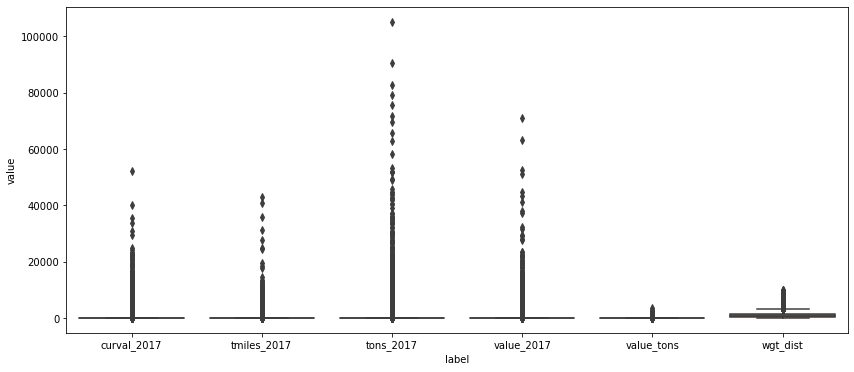

In [11]:
hp.create_boxplots(df_model, continuous)

There is a large spread in values for each variable. Let's look at these plots in log space.

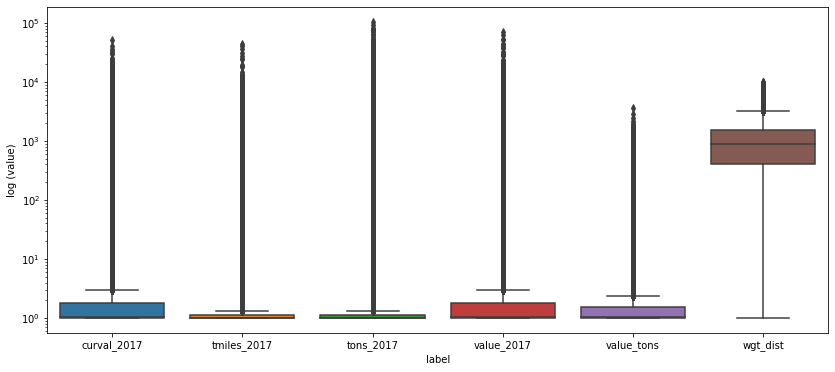

In [12]:
hp.create_boxplots(df_model, continuous, log_scale=True)

There is still a large spread in values. This is further evident if we divide the data into percentiles by tenths and view statistics on the dataset.

In [13]:
df_model.loc[:, continuous].describe(percentiles=[0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).T

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
tons_2017,1814034.0,9.825770,332.737854,0.0,0.0,0.00000,0.000100,0.000600,0.002200,0.007500,0.027400,0.087500,0.224500,1.328600,105266.077100
value_2017,1814034.0,10.113904,192.679806,0.0,0.0,0.00070,0.002700,0.007700,0.021100,0.058300,0.168300,0.440600,1.438800,6.729870,70962.589200
tmiles_2017,1814034.0,2.802205,95.892118,0.0,0.0,0.00000,0.000100,0.000400,0.001600,0.005800,0.020700,0.068500,0.206000,0.991100,43088.903000
curval_2017,1814034.0,9.647496,157.742041,0.0,0.0,0.00070,0.002700,0.007800,0.021300,0.059000,0.170400,0.447010,1.454900,6.794500,52077.219800
wgt_dist,1814034.0,1089.400935,879.965088,0.0,0.0,187.66154,330.188700,500.000000,680.000000,888.234550,1014.416800,1333.333300,1800.000000,2410.207700,9970.000000
value_tons,1814034.0,1.441097,12.224680,0.0,0.0,0.00070,0.002693,0.007656,0.020562,0.054846,0.147147,0.331724,0.831551,2.343597,3625.976734


Except for _wgt\__dist_, almost 90% of the data have values less than 10, while the remainder of values go up to over 10,000. This is a highly skewed dataset with lots of outliers.

To address this skewness, I will first correct for outliers using the Tukey method and see how that improves the distributions.

## Outliers

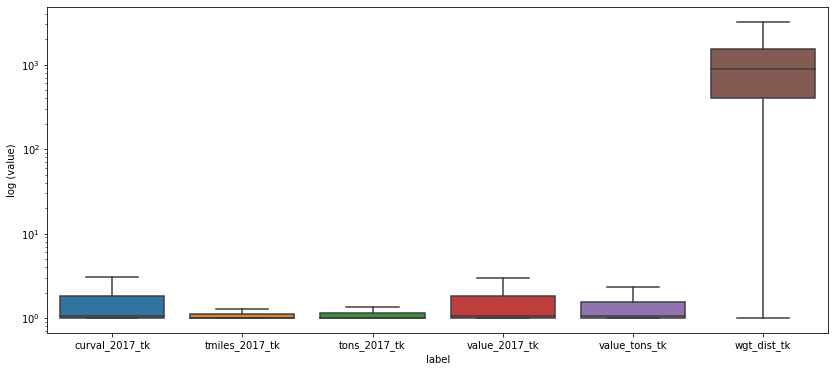

In [14]:
tukeyed = [f'{x}_tk' for x in continuous]
hp.correct_outliers(df_model, continuous)
hp.create_boxplots(df_model, tukeyed, log_scale=True)

Great, a lot of outliers are gone. But, the distributions still appear quite skewed. I will apply a log transformation followed by a normalization transformation and see if that reduces the skewness further.

## Log transformation

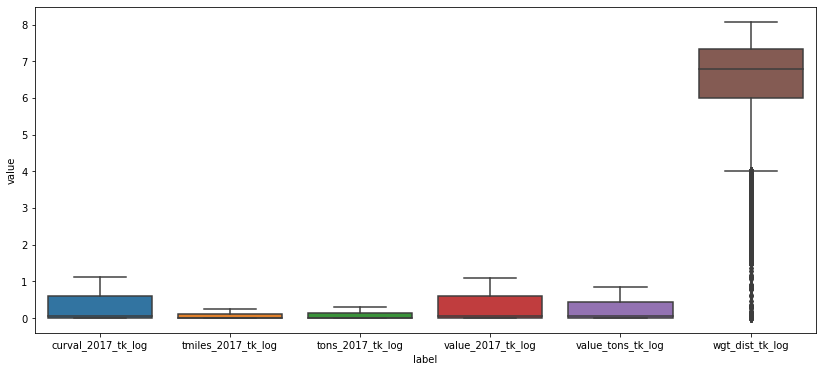

In [15]:
logged = [f'{x}_log' for x in tukeyed]
hp.apply_transform(df_model, tukeyed, 'log')
hp.create_boxplots(df_model, logged)

## Normalized Log Transformation

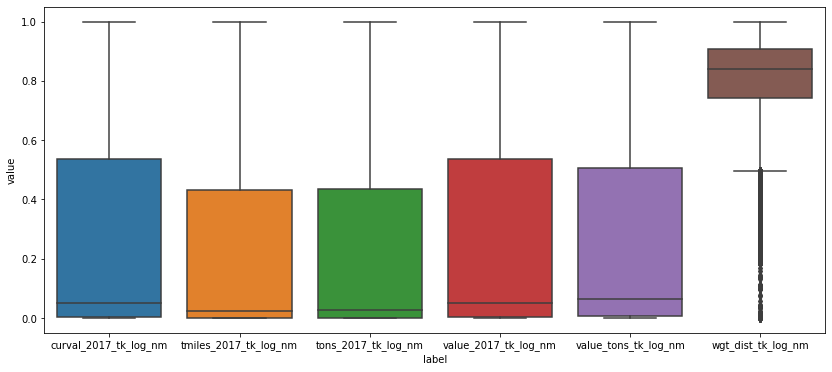

In [16]:
normalized_log = [f'{x}_nm' for x in logged]
hp.apply_transform(df_model, logged, 'normalize')
hp.create_boxplots(df_model, normalized_log)

## Box-Cox Transformation

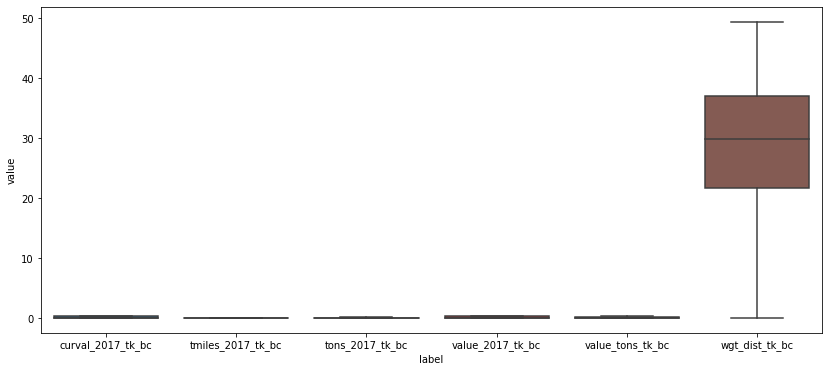

In [17]:
boxcoxed = [f'{x}_bc' for x in tukeyed]
hp.apply_transform(df_model, tukeyed, 'boxcox')
hp.create_boxplots(df_model, boxcoxed)

## Normalized Box-Cox Transformation
Now, I will convert the Box-Coxed transformed variables into values that range from 0 to 1, putting all variables on the same scale.

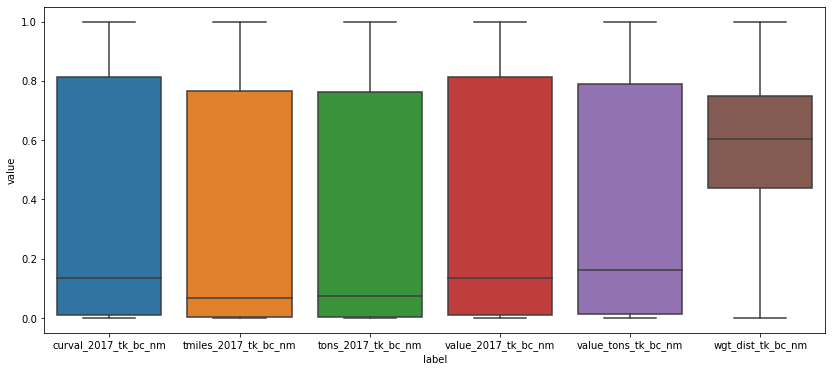

In [18]:
normalized_bc = [f'{x}_nm' for x in boxcoxed]
hp.apply_transform(df_model, boxcoxed, 'normalize')
hp.create_boxplots(df_model, normalized_bc)

## Evaluate Transformation Methods
I will now compare the Box-Cox transformation and the log transformation be performing a normality test for each method. 

In [19]:
print('Log:')
hp.check_for_normality(df_model, normalized_log)

Log:
Normal test results:
* tons_2017_tk_log_nm: normal_stat = 281258.282, p-value = 0.0000.
* value_2017_tk_log_nm: normal_stat = 298147.480, p-value = 0.0000.
* tmiles_2017_tk_log_nm: normal_stat = 285941.901, p-value = 0.0000.
* curval_2017_tk_log_nm: normal_stat = 299558.533, p-value = 0.0000.
* wgt_dist_tk_log_nm: normal_stat = 324405.918, p-value = 0.0000.
* value_tons_tk_log_nm: normal_stat = 273970.269, p-value = 0.0000.


In [20]:
print('Box-Cox:')
hp.check_for_normality(df_model, normalized_bc)

Box-Cox:
Normal test results:
* tons_2017_tk_bc_nm: normal_stat = 2464662.146, p-value = 0.0000.
* value_2017_tk_bc_nm: normal_stat = 11837418.830, p-value = 0.0000.
* tmiles_2017_tk_bc_nm: normal_stat = 1589486.803, p-value = 0.0000.
* curval_2017_tk_bc_nm: normal_stat = 13667275.499, p-value = 0.0000.
* wgt_dist_tk_bc_nm: normal_stat = 56541.314, p-value = 0.0000.
* value_tons_tk_bc_nm: normal_stat = 50492923.923, p-value = 0.0000.


Neither transformation produces normal distributions. They still remain highly skewed. For the moment, I will model the data still including this skewness. Afterwards, I will address this skewness using a different method.

## Correlations
Look for correlated features and remove them. But first, separate target variable from features.

In [21]:
continuous_features = [x for x in normalized_bc if target_var not in x]
target_var = [x for x in normalized_bc if target_var in x][0]

In [22]:
df_model.loc[:, continuous_features].corr()

,tons_2017_tk_bc_nm,value_2017_tk_bc_nm,tmiles_2017_tk_bc_nm,curval_2017_tk_bc_nm,wgt_dist_tk_bc_nm
tons_2017_tk_bc_nm,1.000000,0.809843,0.938822,0.806851,-0.073778
value_2017_tk_bc_nm,0.809843,1.000000,0.758585,0.999178,-0.088436
tmiles_2017_tk_bc_nm,0.938822,0.758585,1.000000,0.756216,0.130923
curval_2017_tk_bc_nm,0.806851,0.999178,0.756216,1.000000,-0.087569
wgt_dist_tk_bc_nm,-0.073778,-0.088436,0.130923,-0.087569,1.000000


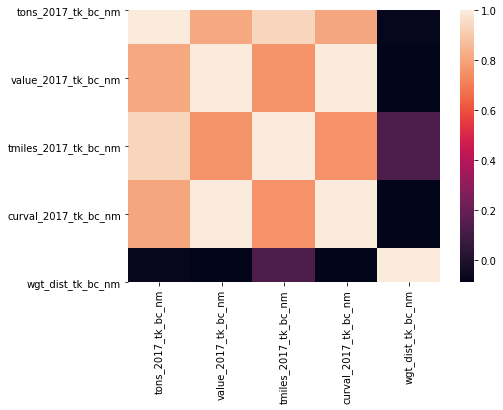

In [23]:
f, axes = plt.subplots(1, 1, figsize=(7, 5))
sns.heatmap(df_model.loc[:, continuous_features].corr(), ax=axes)
plt.show()

**Observations:** There are high correlations between the 'tons' and 'value' features. Since these variables are already described by the target variable, I will remove them.

In [24]:
uncorrelated_features = ['tmiles_2017_tk_bc_nm', 'curval_2017_tk_bc_nm', 'wgt_dist_tk_bc_nm']

In [25]:
df_model.loc[:, uncorrelated_features].corr()

,tmiles_2017_tk_bc_nm,curval_2017_tk_bc_nm,wgt_dist_tk_bc_nm
tmiles_2017_tk_bc_nm,1.000000,0.756216,0.130923
curval_2017_tk_bc_nm,0.756216,1.000000,-0.087569
wgt_dist_tk_bc_nm,0.130923,-0.087569,1.000000


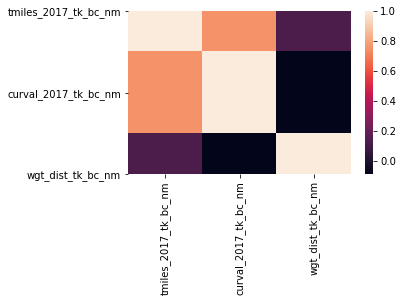

In [26]:
f, axes = plt.subplots(1, 1, figsize=(5, 3))
sns.heatmap(df_model.loc[:, uncorrelated_features].corr(), ax=axes)
plt.show()

## Categorical Variables
Convert categorical variables into dummy variables. First, create a sub-dataset that consists of the good continuous features, the categorical features, and the target variable.

In [27]:
df_subset = df_model.loc[:, uncorrelated_features+categorical+[target_var]].copy()

In [28]:
df_subset = pd.get_dummies(df_subset, columns=categorical, drop_first=True).copy()

## Modeling
As a first step, I will create a simple linear regression model. This will allow me to evaluate the dataset. After which, I can decide whether to do further data manipulation to improve the prediction power of the model. Once I am happy with the linear regression model, I will evaluate a few other regression models to decide which model does the best job at predicting freight value per ton.
### Features and Target
Split dataset into features and target values.

In [29]:
# Split features and target variables
X = df_subset.drop(target_var, axis=1)
y = df_subset[target_var]

### Train/test split
Create train and test datasets. Since the dataset is so large, I will create a small test set so that I have more data to use for training.

In [30]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

### Model 1: Simple Linear Regression

In [31]:
# hp.run_linear_regressor(LinearRegression, X_train, X_test, y_train, y_test, num_folds=5, print_results=True)

In [32]:
# plt.scatter(hp.linear_model_stats['test_data']['y_test'], hp.linear_model_stats['test_data']['y_pred'])
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.title('Normalized Value/Tons')
# plt.xlabel('actual values')
# plt.ylabel('predictions')
# plt.show()

In [33]:
# df_test_data = pd.DataFrame(hp.linear_model_stats['test_data'])

In [34]:
# g = sns.jointplot("y_test", "y_pred", data=df_test_data, kind="reg",
#                   xlim=(0, 1), ylim=(0, 1), height=7)
# plt.show()

The linear regression model is actually performing quite well. The high _R<sup>2</sup>_ value for the training and test sets indicates a good fit. But, notice the large spread spread in values in the scatter plots above. This could be a problem. It seems to indicate the target variable consists of two different distributions.

## Continuous Variable Distributions
Let's return to the dataset and examine the distributions for the continuous variables.

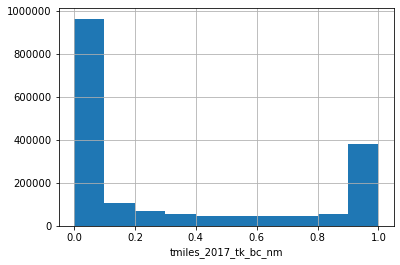

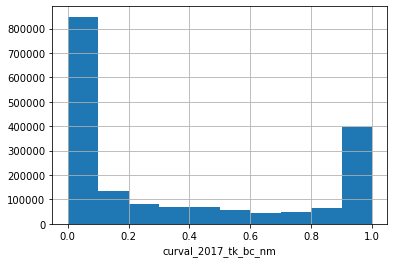

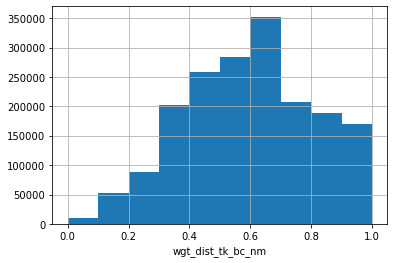

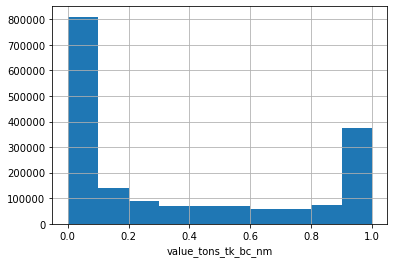

In [35]:
transformed_continuous_variables = uncorrelated_features+[target_var]
for column in transformed_continuous_variables:
    df_model[column].hist(bins=10)
    plt.xlabel(f'{column}')
    plt.show()

**Observations:** All variables, except wgt, show bi-modal distributions. I will split each of these into two separate groups. But, after doing this, the target variable will become a categorical variable. Therefore, the problem statement will change and this will become a classification problem.

I will make the split at 0.6.

In [36]:
variables_to_cut = ['tmiles_2017_tk_bc_nm', 'curval_2017_tk_bc_nm', 'value_tons_tk_bc_nm']
cut_variables = [f'{x}_cut' for x in variables_to_cut]
cut_at = 0.6

In [37]:
for column in variables_to_cut:
    df_model[f'{column}_cut'] = pd.cut(df_model[f'{column}'], bins=[0.0, cut_at, 1.0], labels=['low', 'high'])
    print(df_model[f'{column}_cut'].value_counts())

low     1029025
high     528862
Name: tmiles_2017_tk_bc_nm_cut, dtype: int64
low     1252872
high     556689
Name: curval_2017_tk_bc_nm_cut, dtype: int64
low     1248164
high     562249
Name: value_tons_tk_bc_nm_cut, dtype: int64


Combine variables which will be used for modeling.

In [38]:
new_categorical = categorical + cut_variables
new_categorical_features = [x for x in new_categorical if 'value_tons' not in x]
new_features = new_categorical_features + uncorrelated_features

## New Subset
Now, I will create a new subset using these new categorical variables.

In [39]:
df_subset_2 = df_model.loc[:, new_features+['value_tons_tk_bc_nm_cut']].copy()

### Dummies
Convert the categorical variable to dummy variables.

In [40]:
df_subset_2 = pd.get_dummies(df_subset_2, columns=new_categorical, drop_first=True).copy()

In [41]:
target_var = [x for x in df_subset_2.columns.tolist() if 'value_tons' in x][0]

## Modeling
Now that the target variable is a cateogorical variable, I will try a support vector machine classifer model. First, I will split that data into features and the target.
### Feature and Target

In [42]:
# Resample dataset to make it smaller for faster modeling
df_subset_2 = df_subset_2.sample(frac=0.01).reset_index(drop=True).copy()

In [43]:
X = df_subset_2.drop(target_var, axis=1)
y = df_subset_2[target_var]

### Train/test split
Split that data into train and test sets.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

### Class Imbalance
Let's look at the target variable value counts again.

In [45]:
print(df_subset_2[target_var].value_counts())

0    12624
1     5516
Name: value_tons_tk_bc_nm_cut_high, dtype: int64


There are many more values in the 0 class than the 1 class. Training a model like this will impart a bias towards the 0 class. I will address this issue by up sampling the training data. I will not resample the testing data as that reflects reality.

In [46]:
X_upsampled, y_upsampled = SMOTE().fit_resample(X_train, y_train)

In [47]:
for value in np.unique(y_upsampled):
    print(f'{value}: {len(y_upsampled[y_upsampled == value])}')

0: 10099
1: 10099


Now, I have equal numbers of classes in the target variable.

In [48]:
hp.run_svc_classifier(X_upsampled, X_test, y_upsampled, y_test)

## Model Evaluation
After fitting the model, let's evaluate its performance. I will print some statistics about the model fit, plot a confussion matrix and ROC curve, and create a bar plot showing feature importance.

In [49]:
hp.evaluate_binary_classifier_model()

Train Metrics:
 * score: 98.767%
 * type 1 error: 0.758%
 * type 2 error: 0.475%
 * sensitivity: 98.494%
 * specificity: 99.044%
Test Metrics:
 * score: 97.051%
 * type 1 error: 1.819%
 * type 2 error: 1.130%
 * sensitivity: 94.149%
 * specificity: 98.360%
 * class 0 F1 score: 0.979
 * class 1 F1 score: 0.952


### Accuracy
The test and training scores are both higher thank 97%, indicating a high rate of accuracy and good model generalization. While the high accuracy is a good indication of a good model, since this is a binary classification model, it is important to evaluate how well the model predicts each class.

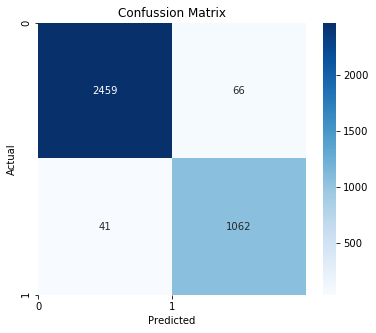

In [50]:
hp.plot_confussion_matrix(hp.binary_classifier_stats['test_data']['y_test'],
                          hp.binary_classifier_stats['test_data']['y_pred'])

### Confussion Matrix
The confussion matrix is a good way to evaluate how well the model classifies each class. In the above plot, you will notice a high number of both true positives and true negatives, with smaller numbers for both false positives and false negatives. A positive prediction is a prediction that a value is of class 0, while a negative prediction is a predication that a value is not of class 0, or, in other words, that it is of class 1. The confussion matrix indicates the model does a good job at predicting each class. The F1 scores for each class are high, which is a further indication that the model does well at classification.

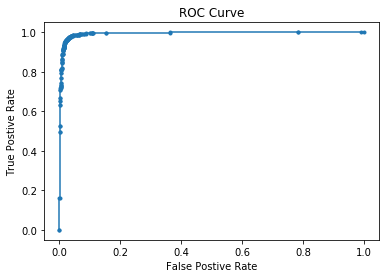

In [51]:
hp.plot_roc_curve()

### ROC Curve
We can gain further information about how well this model performs at classification by plotting an ROC curve. This curve compares the false positive rate with the true positive rate. The sharp elbow shape, curved to the upper left, indicates a good job at model classification.

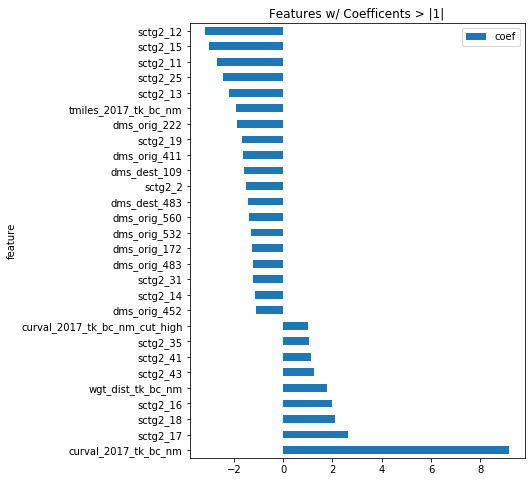

In [52]:
hp.plot_feature_importance(hp.binary_classifier_stats['features'],
                           hp.binary_classifier_stats['train_stats']['coeffs'],
                           coeff_thresh=1)

### Feature Importance
Now that we know this model does a good job at predictions and classifications, let's try to gain something useful from it. One thing we can do is use the model coefficients for the fit to compare the feature importance for each class. This is shown in the bar plot at the bottom of the series of plots shown above. Negatives coefficients are relavent to class 0, while positive coefficients are relavent to class 1. 

The four top features for class 0 are all related to the commodity type. Referring to the [User Guide](https://www.bts.gov/archive/subject_areas/freight_transportation/faf/users_guide/), these features correspond to natural sands, gravel, non-metalic minerals, and coal. Class 0 correponds to low values for value tons. Therefore, this indicates that quarried or mined material has low value per weight.

The top feature for class 1 is _cuval_. Since this is another indicator of value, it makes sense that this has a strong relationship with _value\__tons_. The next most import feature is _wgt\__dist_, which is related to distance. The three relevant features that follow are all commodities. Again, referring to the [User Guide](https://www.bts.gov/archive/subject_areas/freight_transportation/faf/users_guide/), these commodities are creal grains, crude oil and processed gasoline. In conclusion, there is a high value per weight for cereal as well as for gasoline related products.